VERİ SETİNİN YÜKLENMESİ

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_excel("avalanche_discrete_demo.xlsx")
df.head()

,Envanter,Eğim,Bakı,TWI,TRI,Yollara Mesafe,Akarsulara Mesafe,Min Sıcaklık,Yağış,Litoloji
0,0,3,6,2,4,1,1,5,3,3
1,0,2,7,2,4,1,1,5,2,3
2,0,1,5,2,3,1,1,6,4,4
3,0,3,0,3,4,1,1,5,2,3
4,0,3,7,2,4,1,1,5,3,4


BAĞIMLI DEĞİŞKENİN SINIF KONTROLÜ

In [2]:
df['Envanter'].value_counts()

0    1880
1    1880
Name: Envanter, dtype: int64

BAĞIMLI DEĞİŞKENİN VERİ SETİNDEN DÜŞÜRÜLMESİ
(Düşürülmüş haline df_degiskenler ismi verilmiştir-Düşürülmemiş df çerçevesi tekrar kullanılacaktır!)

In [3]:
df_degiskenler=df.drop("Envanter", axis=1)

In [4]:
df_columns=df_degiskenler.columns # Sütun isimlerini atıyoruz. 

ÇOKLU BAĞLANIM (MULTI-COLLINEARITY) TESTİ

In [5]:
# BU TEST İÇİN AŞAĞIDAKİ HAZIR FONKSİYONU KULLANININIZ
import pandas as pd
from sklearn.linear_model import LinearRegression
def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    for feature in features:
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        r2 = LinearRegression().fit(X, y).score(X, y)                
        tolerance[feature] = 1 - r2
        vif[feature] = 1/(tolerance[feature])
    return pd.DataFrame({'VIF': vif, 'Tolerans': tolerance})
calculate_vif(df=df_degiskenler, features=df_columns) # df=bağımsız degiskenlerden olusan veri seti (burada df_degiskenler)

,VIF,Tolerans
Eğim,1.374124,0.727737
Bakı,1.022779,0.977729
TWI,1.151680,0.868297
TRI,1.032780,0.968260
Yollara Mesafe,1.254716,0.796993
Akarsulara Mesafe,1.021175,0.979264
Min Sıcaklık,1.523685,0.656304
Yağış,1.160075,0.862013
Litoloji,1.108056,0.902481


KORELASYON MATRİSİ

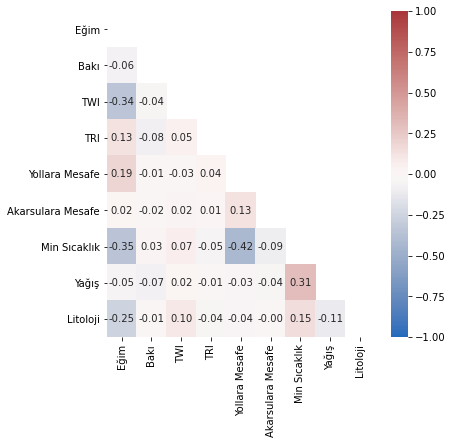

In [6]:
fig = plt.figure(figsize=(6,6))
mask = np.triu(np.ones_like(df_degiskenler.corr(), dtype=bool))
heatmap = sns.heatmap(df_degiskenler.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='vlag', fmt=".2f")

BAĞIMLI VE BAĞIMSIZ DEĞİŞKENLERİN AYRILMASI (df veri setine geri döndük!!!)

In [7]:
X = df.iloc[:,1:].values
X.shape

(3760, 9)

In [8]:
y = df.iloc[:,0].values
y.shape

(3760,)

In [9]:
column_names = df.iloc[:,1:].columns
column_names

Index(['Eğim', 'Bakı', 'TWI', 'TRI', 'Yollara Mesafe', 'Akarsulara Mesafe',
       'Min Sıcaklık', 'Yağış', 'Litoloji'],
      dtype='object')

EĞİTİM VE TEST VERİ SETİNİN AYRILMASI

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=43, stratify=y)

GEREKLİ KÜTÜPHANELERİN YÜKLENMESİ

In [11]:
from sklearn.ensemble import RandomForestClassifier #SADECE RANDOM FOREST KULLANACAĞIM. 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, roc_curve, roc_auc_score, auc,precision_recall_curve, average_precision_score

BAŞLANGIÇ (DEFAULT) KOŞULLARLA RANDOM FOREST EĞİTİMİ

In [12]:
RFC = RandomForestClassifier(random_state=42)

RFC.fit(X_train,y_train)
print("score train RFC: ",RFC.score(X_train,y_train))
print("score test RFC: ",RFC.score(X_test,y_test))

score train RFC:  0.9753039513677811
score test RFC:  0.8865248226950354


HİPERPARAMETRELERİN UYUMLANDIRILMASI İÇİN SÖZLÜK YAZALIM. EN İYİ KOMBİNASYONU EKRANA VERELİM.

In [13]:
from sklearn.model_selection import GridSearchCV
 
# Farklı hiperparametre değerlerini içeren sözlüğümüzü yazalım:

param_grid = {'n_estimators': [50,100,200],
              'max_depth': [10,20,50],
              'min_samples_split': [5,10,20]}
 
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True)
 
# Kombinasyonları tek tek eğitelim: 

grid.fit(X_train, y_train)

# Optimizasyondaki en iyi hiperparametre kombinasyonunu ekrana verelim.
print(grid.best_params_)


# En iyi sonucu veren hiperparametre kombinasyonunun doğruluğunu ekrana verelim.
print(grid.best_score_)

{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
0.8989372371050713


UYUMLANDIRILMIŞ HİPERPARAMETRE DEĞERLERİ İLE RANDOM FOREST YENİDEN EĞİTELİM. MODEL ADI RFC_tuned OLDU. DİKKAT!!!

In [14]:
RFC_tuned = RandomForestClassifier(random_state=42,n_estimators=200, max_depth=10,min_samples_split=10)
RFC_tuned.fit(X_train,y_train)
print("score train RFC tuned: ",RFC_tuned.score(X_train,y_train))
print("score test RFC tuned: ",RFC_tuned.score(X_test,y_test))

score train RFC tuned:  0.9217325227963525
score test RFC tuned:  0.8962765957446809


BURADA KARMAŞIKLIK MATRİSİ VE DİĞER PERFORMANS METRİKLERİNİ ÇIKARALIM.

accuracy RFC:  0.8962765957446809
precision RFC:  0.8718801996672213
recall RFC:  0.9290780141843972
f1 score RFC:  0.8995708154506439


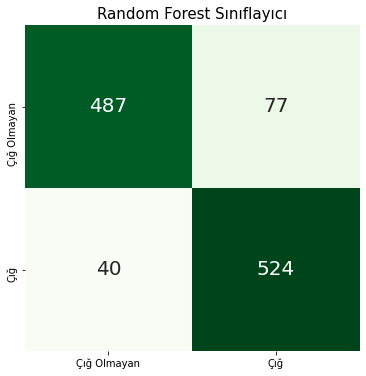

In [15]:
y_pred_RFC = RFC_tuned.predict(X_test)
df_cm_RFC= pd.DataFrame(confusion_matrix(y_test,y_pred_RFC), index = [i for i in ["Çığ Olmayan",  'Çığ']],columns = [i for i in ["Çığ Olmayan",  'Çığ']])
fig = plt.figure(figsize=(6, 6))
plt.title('Random Forest Sınıflayıcı', size=15)
sns.heatmap(df_cm_RFC, annot = True, fmt='g', cmap='Greens', cbar=False, annot_kws={"size": 20})
print("accuracy RFC: ", accuracy_score(y_test,y_pred_RFC)) 
print("precision RFC: ", precision_score(y_test,y_pred_RFC)) 
print("recall RFC: ", recall_score(y_test,y_pred_RFC)) 
print("f1 score RFC: ", f1_score(y_test,y_pred_RFC)) 

ROC EĞRİSİ

In [16]:
y_pred_prob_RFC = RFC_tuned.predict_proba(X_test)[:,1]
fpr_RFC, tpr_RFC, thresholds_RFC = roc_curve(y_test, y_pred_prob_RFC)
roc_auc_RFC = auc(fpr_RFC, tpr_RFC)

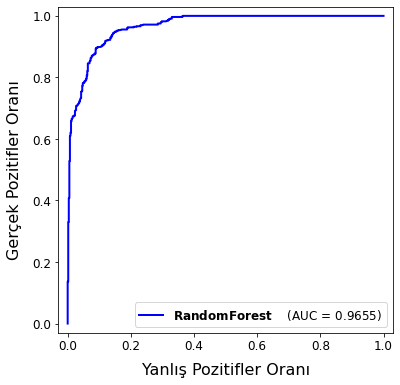

In [17]:
plt.figure(figsize=(6,6))
plt.plot(fpr_RFC, tpr_RFC, label=r'$\bf{}$'.format('Random Forest')+ '    (AUC = %0.4f)' % roc_auc_RFC, color='b', linewidth=2)
plt.xlabel('Yanlış Pozitifler Oranı', size=16, labelpad=10)
plt.ylabel('Gerçek Pozitifler Oranı', size=16, labelpad=10)
plt.legend(loc='lower right',
          fancybox=True, shadow=False, ncol=1,fontsize='large')
plt.xlim(-0.03,1.03)
plt.ylim(-0.03,1.03)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(labeltop=False, labelright=False)
plt.show()

FAKTÖRLERİN EĞİTİME KATKI (ÖNEM) DERECESİ - grafik ya da tablo!

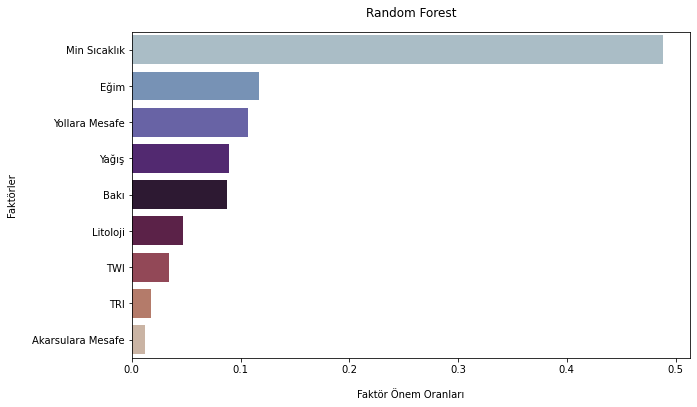

,feature_importances,features
6,0.488732,Min Sıcaklık
0,0.117012,Eğim
4,0.106856,Yollara Mesafe
7,0.089009,Yağış
1,0.087261,Bakı
8,0.046941,Litoloji
2,0.034053,TWI
3,0.017785,TRI
5,0.012351,Akarsulara Mesafe


In [18]:
fi_df = pd.DataFrame({
    "feature_importances" : RFC.feature_importances_,
    "features" : column_names
})

fi_df.sort_values(by="feature_importances", ascending=False, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x="feature_importances", y="features", palette="twilight", data=fi_df)
plt.xlabel("Faktör Önem Oranları",labelpad=15)
plt.ylabel("Faktörler",labelpad=15)
plt.title("Random Forest", pad=15)
plt.show()

fi_df